# 교차검증 하이퍼파라미터를 이용한 최적의 모델을 만드는 방법
- GridSearchCV를 이용한 파라미터 튜닝

In [122]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# seaborn lib add
import seaborn as sns

from glob import glob

%matplotlib inline

import json

import warnings
warnings.filterwarnings(action = 'ignore') 

from datetime import date, datetime, timedelta
from dateutil.parser import parse

print("numpy version:",np.__version__) 
print("pandas version:",pd.__version__)

# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 


# 차트 축 <- 음수 부호 지원
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris, load_breast_cancer

from sklearn.model_selection import train_test_split, KFold , StratifiedKFold, cross_val_score , cross_validate,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder,StandardScaler, MinMaxScaler
import graphviz

import missingno as msno

sklearn.__version__

numpy version: 1.20.1
pandas version: 1.2.4


'0.24.1'

Decision Tree의 장단점

- 장점
    - 쉽고 직관적이다.
    - 각 피처의 스케일링과 정규화같은 전처리 작업의 영향도가 크지 않다.
- 단점
    - 규칙을 추가하여 서브트리를 만들어 나갈수록 모델이 복잡해지고, 과적합에 빠지기 쉽다.
        → 트리의 크기를 사전에 제한하는 튜닝이 필요!

### GridSearchCV를 이용한 파라미터 튜닝
- min_samples_split : 노드를 분리하기 위한 최소한의 샘플 수(과적합을 제어할 때 사용)
- min_samples_leaf  : 리프노드가 되기 위한 최소한의 샘플 수(과적합을 제어할 때 사용)
- max_depth         : 트리의 최대 깊이
- max_leaf_nodes    : 리프노드의 최대 수

In [17]:
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data  , 
                                                    iris.target ,
                                                    test_size = 0.2 , 
                                                    shuffle = False  ,
                                                    random_state = 200 ) 

dtc = DecisionTreeClassifier(random_state = 100,criterion = 'entropy') 
dtc.fit(X_train , y_train)

DecisionTreeClassifier(criterion='entropy', random_state=100)

In [18]:
from sklearn.tree import export_graphviz

export_graphviz(dtc,
               out_file = 'iris_tree.dot',
               class_names = iris.target_names,
               feature_names = iris.feature_names,
               impurity = True,
               filled =  True)

#### impurity =True
#### - 불순도란 다양한 범주(Factor)들의 개체들이 얼마나 포함되어 있는가를 의미한다. 쉽게 말하면 여러 가지의 클래스가 섞여 있는 정도를 말한다. 반대로 순수도(purity)는 같은 클래스끼리 얼마나 많이 포함되어 있는지를 말한다.
- 이 불순도를 수치화한 지표로 엔트로피(Entropy), 지니계수(Gini Index) 등이 있는데, 불순도를 엔트로피로 계산한 알고리즘이 ID3이며, 지니계수로 계산한 알고리즘이 CART알고리즘이다.
#### - 엔트로피(Entropy)
- 엔트로피란 데이터의 분포의 순수도(purity)를 나타내는 척도이며, 데이터의 순도가 높을 수록 엔트로피의 값은 낮아지고, 많이 섞이면 섞일수록 엔트로피의 값이 커지게 된다.

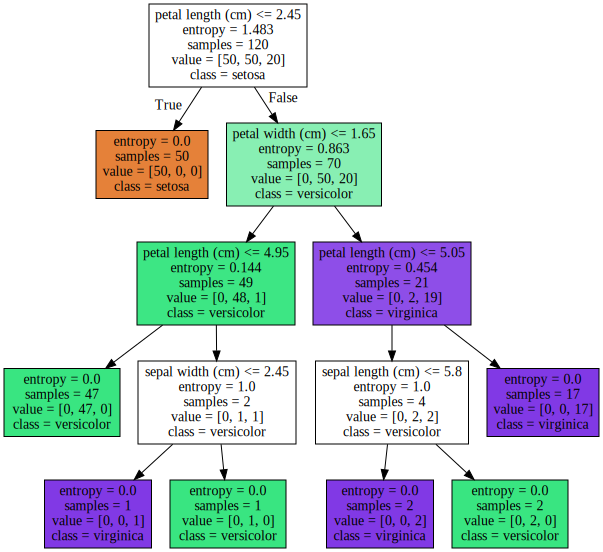

In [19]:
import os

os.environ['PATH'] += os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'
with open('./iris_tree.dot') as file:
    dot_graph = file.read()
    
graphviz.Source(dot_graph)

#### Decision Tree에서 사용할 수 있는 파라미터
- criterion : 분할 품질을 측정하는 기능 (default : gini)
- splitter : 각 노드에서 분할을 선택하는 데 사용되는 전략 (default : best)
- max_depth : 트리의 최대 깊이 (값이 클수록 모델의 복잡도가 올라간다.)
- min_samples_split : 자식 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
- min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
- min_weight_fraction_leaf : min_sample_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
- max_features : 각 노드에서 분할에 사용할 특징의 최대 수
- random_state : 난수 seed 설정
- max_leaf_nodes : 리프 노드의 최대수
- min_impurity_decrease : 최소 불순도
- min_impurity_split : 나무 성장을 멈추기 위한 임계치
- class_weight : 클래스 가중치
- presort : 데이터 정렬 필요 여부

In [33]:
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data  , 
                                                    iris.target ,
                                                    test_size = 0.2 ,
                                                    random_state = 200 ) 

gscv_dtc = DecisionTreeClassifier()
param={
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[1,2,3],
    'min_samples_split':[2,3]
}


In [34]:
grid_gscv_tree = GridSearchCV(gscv_dtc, # 교차검증과 튜닝이 된 객체가 만들어짐.
                             param_grid=param,
                             cv=3,
                             refit=True # 최적의 하이퍼 파라미터를 찾아서 재학습하겠다는 의미
                             )

In [35]:
grid_gscv_tree.fit(X_train,y_train)
grid_gscv_tree.cv_results_

{'mean_fit_time': array([0.00166249, 0.00117604, 0.00199231, 0.00132958, 0.00233285,
        0.00265988, 0.00166353, 0.00099707, 0.00099802, 0.00099699,
        0.00166154, 0.00133125, 0.00099707, 0.00099659, 0.00166583,
        0.00132942, 0.00033196, 0.00099762, 0.00133141, 0.00133038,
        0.00150013, 0.00099659, 0.00232697, 0.00099707]),
 'std_fit_time': array([4.69347668e-04, 2.52768999e-04, 2.97996732e-06, 4.69403511e-04,
        4.66095185e-04, 9.42010569e-04, 9.41167728e-04, 9.73339773e-07,
        9.73339773e-07, 8.14296178e-04, 1.24292391e-03, 4.69922327e-04,
        1.36267568e-06, 1.34869915e-06, 4.72906162e-04, 4.69853077e-04,
        4.69459697e-04, 2.50307969e-06, 1.24366825e-03, 4.69010777e-04,
        4.11205954e-04, 1.94667955e-07, 1.88042379e-03, 3.72930152e-06]),
 'mean_score_time': array([0.00097489, 0.00066519, 0.00099707, 0.0009973 , 0.        ,
        0.00099794, 0.0016617 , 0.        , 0.0003318 , 0.00033243,
        0.00099834, 0.00066439, 0.00099786, 0.00

In [36]:
score_frm = pd.DataFrame(grid_gscv_tree.cv_results_)
score_frm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001662,4.693477e-04,0.000975,3.137900e-05,gini,1,2,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.650,0.650,0.650,0.650000,0.000000e+00,18
1,0.001176,2.527690e-04,0.000665,4.703589e-04,gini,1,2,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.650,0.650,0.650,0.650000,0.000000e+00,18
2,0.001992,2.979967e-06,0.000997,1.917257e-06,gini,1,3,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.650,0.650,0.650,0.650000,0.000000e+00,18
3,0.001330,4.694035e-04,0.000997,7.018853e-07,gini,1,3,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.650,0.650,0.650,0.650000,0.000000e+00,18
4,0.002333,4.660952e-04,0.000000,0.000000e+00,gini,2,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.875,0.950,0.900,0.908333,3.118048e-02,6
5,0.002660,9.420106e-04,0.000998,1.988410e-06,gini,2,2,random,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.800,0.875,0.825,0.833333,3.118048e-02,13
6,0.001664,9.411677e-04,0.001662,1.694298e-03,gini,2,3,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.875,0.950,0.900,0.908333,3.118048e-02,6
7,0.000997,9.733398e-07,0.000000,0.000000e+00,gini,2,3,random,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.675,0.875,0.775,0.775000,8.164966e-02,15
8,0.000998,9.733398e-07,0.000332,4.692349e-04,gini,3,2,best,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.950,0.950,0.950,0.950000,1.110223e-16,1
9,0.000997,8.142962e-04,0.000332,4.701340e-04,gini,3,2,random,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.875,0.950,0.850,0.891667,4.249183e-02,10


In [37]:
score_frm[['params','rank_test_score']]

,params,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",18
1,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",18
2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",18
3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",18
4,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",6
5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",13
6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",6
7,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",15
8,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",1
9,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",10


In [38]:
print('최적의 파라미터 확인')
print()
print(grid_gscv_tree.best_params_)
print('높은 정확도 확인')
print()
print(grid_gscv_tree.best_score_)

최적의 파라미터 확인

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'splitter': 'best'}
높은 정확도 확인

0.9499999999999998


In [39]:
estimator=grid_gscv_tree.best_estimator_
y_predict = estimator.predict(X_test)
print('answer : \n',y_test)
print()
print('guess : \n',y_predict)
print()
print('테스트 정확도 : ', accuracy_score(y_test, y_predict))

answer : 
 [1 2 0 0 1 2 1 1 1 2 2 0 0 0 2 0 1 0 1 2 0 1 2 0 0 0 1 2 2 1]

guess : 
 [1 2 0 0 1 2 1 1 1 2 2 0 0 0 2 0 1 0 1 2 0 1 1 0 0 0 1 2 2 1]

테스트 정확도 :  0.9666666666666667


sepal length (cm) 0.0
sepal width (cm) 0.0
petal length (cm) 0.06986145283641192
petal width (cm) 0.9301385471635881


<AxesSubplot:>

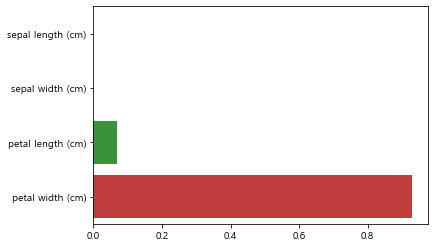

In [63]:
# feature importance : 트리 분류 모델 형성에 각 특성이 얼마나 잘 작용했는지를 평가하는 지표
# 해당 지표는 0~1사이의 값을 가지며, 0이면 특성이 전혀 작용하지 않았음을 의미하고, 1은 완전하게 작용하였음을 의미
# 특성 중요도 전체의 합은 1이다.
for name, value in zip(iris.feature_names , estimator.feature_importances_) :
    print(name, value)

sns.barplot(x = estimator.feature_importances_ , y = iris.feature_names)


## breast_cancer 데이터를 이용한 GridSearchCV실습

In [41]:
cancer = load_breast_cancer()
print('type:',type(cancer))
print('keys:',cancer.keys())

type: <class 'sklearn.utils.Bunch'>
keys: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [45]:
print('target: \n',cancer.target)

target: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 

In [49]:
cancer_frm = pd.DataFrame(data=cancer.data,
                         columns = cancer.feature_names)
cancer_frm['target'] = cancer.target
cancer_frm

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [59]:
# DecisionTree Estimator를 이용해서 train test : 7.3으로 두고 
# 학습, 예측, 학습결과를 평가, graphviz시각화
X_train,X_test,y_train,y_test = train_test_split(cancer.data,
                                                 cancer.target,
                                                test_size=0.3,
                                                random_state = 200)

print('train data:',X_train)
print('train label:',y_train)
print()
print('test data:',X_test)
print('test data:',y_test)

cancer_dtc = DecisionTreeClassifier()
cancer_dtc.fit(X_train,y_train)

y_predict = cancer_dtc.predict(X_test)
print('y_test:',y_test)
print('y_predict:',y_predict)
print('예측정확도 : {0:.2f}'.format(accuracy_score(y_test, y_predict)))



train data: [[1.327e+01 1.476e+01 8.474e+01 ... 1.001e-01 2.027e-01 6.206e-02]
 [1.136e+01 1.757e+01 7.249e+01 ... 8.698e-02 2.973e-01 7.745e-02]
 [8.734e+00 1.684e+01 5.527e+01 ... 0.000e+00 2.445e-01 8.865e-02]
 ...
 [1.346e+01 1.875e+01 8.744e+01 ... 1.427e-01 3.518e-01 8.665e-02]
 [1.026e+01 1.471e+01 6.620e+01 ... 4.074e-02 2.434e-01 8.488e-02]
 [1.286e+01 1.800e+01 8.319e+01 ... 7.926e-02 2.779e-01 7.918e-02]]
train label: [1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0
 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0
 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0
 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0
 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0
 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1

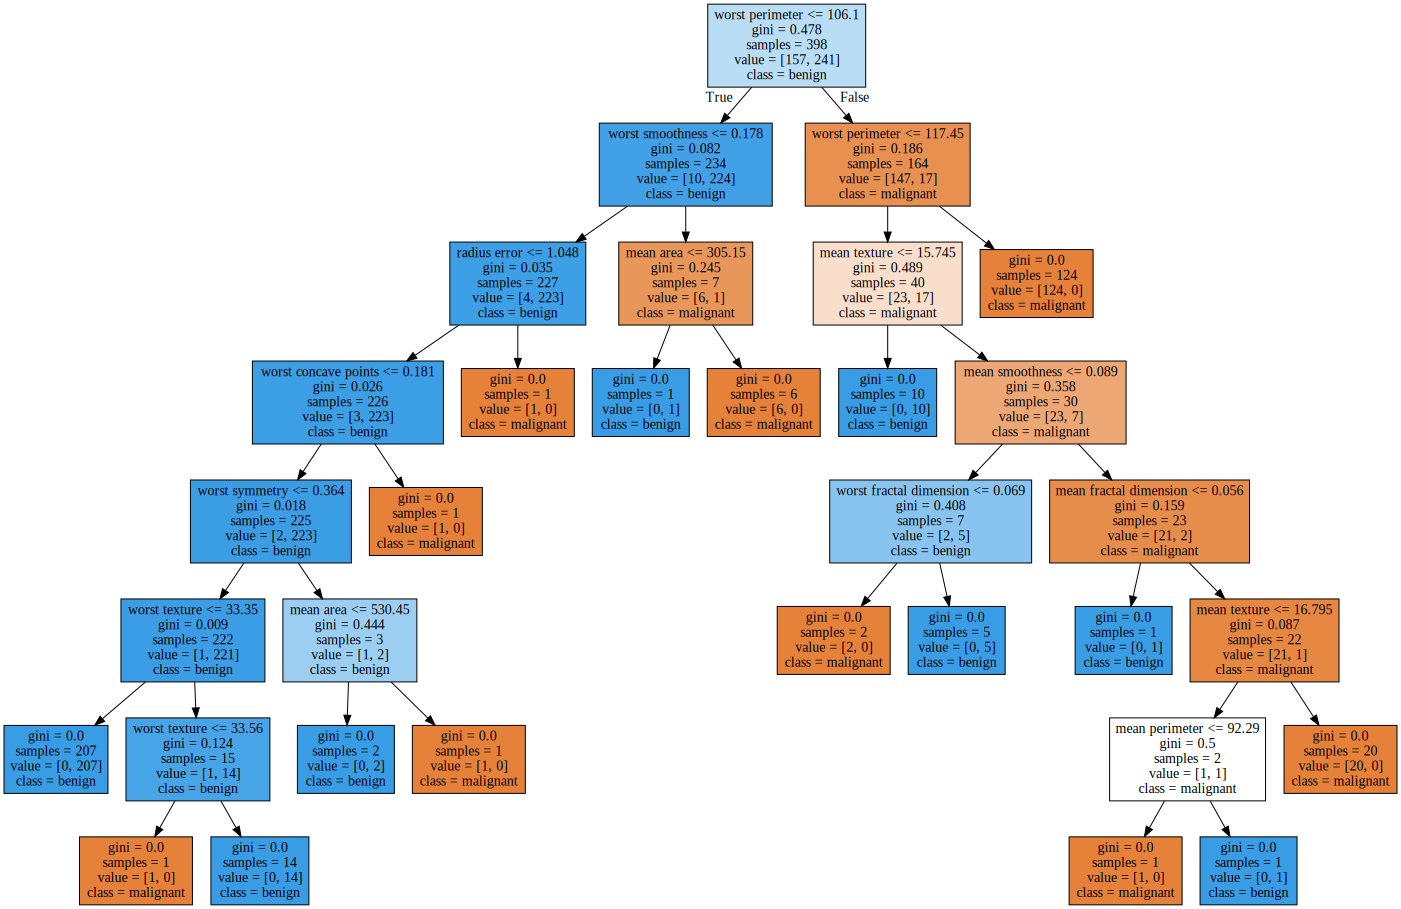

In [60]:

export_graphviz(cancer_dtc,
               out_file = 'cancer_tree.dot',
               class_names = cancer.target_names,
               feature_names = cancer.feature_names,
               impurity = True,
               filled =  True)

os.environ['PATH'] += os.pathsep+'C:/Program Files (x86)/Graphviz2.38/bin/'
with open('./cancer_tree.dot') as file:
    dot_graph = file.read()
    
graphviz.Source(dot_graph)

In [65]:
# 교차검증
fold_cancer = load_breast_cancer()
features = fold_cancer.data
label = fold_cancer.target

fold_dt_clf = DecisionTreeClassifier()

#5개의 폴더 세트를 분리하여 각 폴더 세트별 정확도를 담기
cv_accuracy=[]
# kfold 사용시,
kfold = KFold(n_splits=5)

n_iter=0
for train_idx, test_idx in kfold.split(features):
#     print('train_idx : ',train_idx)
#     print('test_idx : ',test_idx)
        X_train, X_val = features[train_idx], features[test_idx]
        y_train, y_val = label[train_idx], label[test_idx]
        
        # 학습과 예측
        fold_dt_clf.fit(X_train,y_train)
        fold_pred = fold_dt_clf.predict(X_val)
        
        n_iter += 1
        
        #학습 데이터에 대한 검증 정확도 측정
        acc = accuracy_score(y_val, fold_pred)
        print('{} 교차검증 정확도 : {}, 학습 데이터 크기 : {}, 검증데이터 크기 : {}'.format(n_iter, acc, X_train.shape[0],X_val.shape[0]))
        
        cv_accuracy.append(acc)
print('교차검증 평균 정확도 : ', np.mean(cv_accuracy))



1 교차검증 정확도 : 0.8771929824561403, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
2 교차검증 정확도 : 0.9298245614035088, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
3 교차검증 정확도 : 0.9473684210526315, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
4 교차검증 정확도 : 0.9298245614035088, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
5 교차검증 정확도 : 0.8761061946902655, 학습 데이터 크기 : 456, 검증데이터 크기 : 113
교차검증 평균 정확도 :  0.912063344201211


In [67]:
#  Stratified KFold 사용시,
skf = StratifiedKFold(n_splits = 5)
n_iter=0
for train_idx, test_idx in skf.split(features,label):
#     print('train_idx : ',train_idx)
#     print('test_idx : ',test_idx)
        X_train, X_val = features[train_idx], features[test_idx]
        y_train, y_val = label[train_idx], label[test_idx]
        
        # 학습과 예측
        fold_dt_clf.fit(X_train,y_train)
        fold_pred = fold_dt_clf.predict(X_val)
        
        n_iter += 1
        
        #학습 데이터에 대한 검증 정확도 측정
        acc = accuracy_score(y_val, fold_pred)
        print('{} 교차검증 정확도 : {}, 학습 데이터 크기 : {}, 검증데이터 크기 : {}'.format(n_iter, acc, X_train.shape[0],X_val.shape[0]))
        
        cv_accuracy.append(acc)
print('교차검증 평균 정확도 : ', np.mean(cv_accuracy))

1 교차검증 정확도 : 0.9035087719298246, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
2 교차검증 정확도 : 0.9035087719298246, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
3 교차검증 정확도 : 0.9122807017543859, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
4 교차검증 정확도 : 0.9649122807017544, 학습 데이터 크기 : 455, 검증데이터 크기 : 114
5 교차검증 정확도 : 0.8938053097345132, 학습 데이터 크기 : 456, 검증데이터 크기 : 113
교차검증 평균 정확도 :  0.9138332557056359


In [70]:
# GridSearchCV를 이용한 하이터파라미터 튜닝을 진행

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data  , 
                                                    cancer.target ,
                                                    test_size = 0.3 ,
                                                    random_state = 200 ) 

gscv_dtc = DecisionTreeClassifier()
param={
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[1,2,3],
    'min_samples_split':[2,3]
}


In [71]:
grid_gscv_tree = GridSearchCV(gscv_dtc, # 교차검증과 튜닝이 된 객체가 만들어짐.
                             param_grid=param,
                             cv=3,
                             refit=True 
                             )

In [72]:
grid_gscv_tree.fit(X_train,y_train)
grid_gscv_tree.cv_results_

{'mean_fit_time': array([0.00320347, 0.00166273, 0.00365623, 0.00166225, 0.00365575,
        0.00166035, 0.00365663, 0.0009973 , 0.00399017, 0.00099738,
        0.00398858, 0.00166392, 0.00365671, 0.00158954, 0.00365702,
        0.00099778, 0.00498573, 0.0013299 , 0.00631618, 0.0015955 ,
        0.00598311, 0.00099691, 0.0053184 , 0.00166512]),
 'std_fit_time': array([5.74429522e-04, 4.66652505e-04, 4.70247888e-04, 4.71202581e-04,
        9.40662918e-04, 4.67847039e-04, 4.72054979e-04, 1.36267568e-06,
        8.13519129e-04, 1.85019918e-06, 8.15561398e-04, 4.72387654e-04,
        4.71430981e-04, 4.24797281e-04, 9.41281630e-04, 8.14490792e-04,
        8.16049002e-04, 4.71539032e-04, 9.40382116e-04, 4.34303422e-04,
        1.62995566e-03, 2.14429499e-06, 9.41054854e-04, 9.38701897e-04]),
 'mean_score_time': array([0.00129366, 0.00099715, 0.00100104, 0.0006636 , 0.00099802,
        0.00100279, 0.00099659, 0.00099667, 0.00099667, 0.0006632 ,
        0.00099715, 0.00066582, 0.00033283, 0.00

In [73]:
score_frm1 = pd.DataFrame(grid_gscv_tree.cv_results_)
score_frm1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003203,0.000574,0.001294,4.202893e-04,gini,1,2,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.917293,0.902256,0.901515,0.907021,0.007270,15
1,0.001663,0.000467,0.000997,8.156628e-04,gini,1,2,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.879699,0.789474,0.840909,0.836694,0.036955,23
2,0.003656,0.000470,0.001001,2.642995e-06,gini,1,3,best,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.917293,0.902256,0.901515,0.907021,0.007270,15
3,0.001662,0.000471,0.000664,4.692353e-04,gini,1,3,random,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.857143,0.894737,0.878788,0.876889,0.015406,20
4,0.003656,0.000941,0.000998,1.946680e-07,gini,2,2,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.924812,0.902256,0.916667,0.914578,0.009326,10
5,0.001660,0.000468,0.001003,6.072267e-06,gini,2,2,random,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.917293,0.887218,0.909091,0.904534,0.012694,19
6,0.003657,0.000472,0.000997,3.754620e-06,gini,2,3,best,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.932331,0.902256,0.916667,0.917084,0.012282,9
7,0.000997,0.000001,0.000997,1.266589e-06,gini,2,3,random,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.939850,0.932331,0.939394,0.937191,0.003442,2
8,0.003990,0.000814,0.000997,8.153714e-04,gini,3,2,best,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.924812,0.894737,0.916667,0.912072,0.012701,11
9,0.000997,0.000002,0.000663,4.689552e-04,gini,3,2,random,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.954887,0.909774,0.924242,0.929635,0.018808,5


In [75]:
score_frm1[['params','rank_test_score']]

,params,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",15
1,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",23
2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",15
3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",20
4,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",10
5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",19
6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",9
7,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2
8,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",11
9,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",5


In [76]:
print('최적의 파라미터 확인')
print()
print(grid_gscv_tree.best_params_)
print('높은 정확도 확인')
print()
print(grid_gscv_tree.best_score_)

최적의 파라미터 확인

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'splitter': 'random'}
높은 정확도 확인

0.9421850079744817


In [77]:
estimator=grid_gscv_tree.best_estimator_
y_predict = estimator.predict(X_test)
print('answer : \n',y_test)
print()
print('guess : \n',y_predict)
print()
print('테스트 정확도 : ', accuracy_score(y_test, y_predict))

answer : 
 [1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0]

guess : 
 [0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1
 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0]

테스트 정확도 :  0.9181286549707602


mean radius 0.5329312763386425
mean texture 0.03201799278822968
mean perimeter 0.0
mean area 0.0
mean smoothness 0.0
mean compactness 0.012550231966165138
mean concavity 0.0
mean concave points 0.0
mean symmetry 0.0
mean fractal dimension 0.0
radius error 0.008027672123297061
texture error 0.0
perimeter error 0.0
area error 0.0
smoothness error 0.0
compactness error 0.0
concavity error 0.0
concave points error 0.0
symmetry error 0.0
fractal dimension error 0.0
worst radius 0.0
worst texture 0.0
worst perimeter 0.10467567161184672
worst area 0.0
worst smoothness 0.0
worst compactness 0.0
worst concavity 0.0
worst concave points 0.309797155171819
worst symmetry 0.0
worst fractal dimension 0.0


<AxesSubplot:>

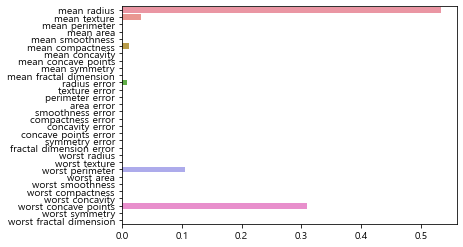

In [178]:
# 피처의 중요도를 시각화
# feature importance : 트리 분류 모델 형성에 각 특성이 얼마나 잘 작용했는지를 평가하는 지표
# 해당 지표는 0~1사이의 값을 가지며, 0이면 특성이 전혀 작용하지 않았음을 의미하고, 1은 완전하게 작용하였음을 의미
# 특성 중요도 전체의 합은 1이다.
for name, value in zip(cancer.feature_names , estimator.feature_importances_) :
    print(name, value)

sns.barplot(x = estimator.feature_importances_ , y = cancer.feature_names)


# 데이터 전처리
- 데이터 인코딩(ML에서는 문자열 값을 입력값으로 허용하지 않는다.) → 숫자형 변환
- 방법) 레이블 인코딩, 원-핫인코딩
- 주의사항) 회귀 알고리즘에서는 적용X, 트리계열의 알고리즘에서는 적용 O
- 트리계열의 알고리즘 중에서 성능이 떨어지는 단점이 있을 수 있다. 왜냐하면 숫자의 특성이 반영되기 때문에

- 입력값으로 결측값을 허용하지 않는다. → 고정된 다른 값으로 변환
- 피처 스케일링 →  정규화(0과 1사이의 값으로 변환 - MinMaxScalar, 표준화(정규분포를 따르는 형식으로 평균이 0 분산1 가부시안분포 변환 - StandardScalar)

- LabelEncoder : fit(), transform()
- 문자열 피처를 숫자형으로 변환

In [83]:
# 레이블 인코딩
label_items=['낫또','집밥','ABC 쥬스','제육볶음','낫또']
encoder = LabelEncoder()
labels=encoder.fit(label_items).transform(label_items)
print('lables:',labels)
print('인코딩 클래스 : ',encoder.classes_)
print('디코딩 원본 값 : ',encoder.inverse_transform(labels))

lables: [1 3 0 2 1]
인코딩 클래스 :  ['ABC 쥬스' '낫또' '제육볶음' '집밥']
디코딩 원본 값 :  ['낫또' '집밥' 'ABC 쥬스' '제육볶음' '낫또']


In [89]:
# 원 - 핫 인코딩
label_items=['낫또','집밥','ABC 쥬스','제육볶음','낫또']
encoder = LabelEncoder()
digit_labels=encoder.fit(label_items).transform(label_items)
print('type:', type(digit_labels))
print()
print('2차원 데이터 변환')
digit_labels=digit_labels.reshape(-1,1)
print('shape',digit_labels.shape)
print(digit_labels)

print('--One-Hot Encoding--')
one_hot_encoder = OneHotEncoder()
one_hot_encoder_labels = one_hot_encoder.fit(digit_labels).transform(digit_labels)
print('shape:',one_hot_encoder_labels.shape)
print()
print(one_hot_encoder_labels.toarray())

type: <class 'numpy.ndarray'>

2차원 데이터 변환
shape (5, 1)
[[1]
 [3]
 [0]
 [2]
 [1]]
--One-Hot Encoding--
shape: (5, 4)

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [90]:
encoder_frm = pd.DataFrame({
    'label_items' : ['낫또','집밥','ABC 쥬스','제육볶음','낫또']
})

pd.get_dummies(encoder_frm)

,label_items_ABC 쥬스,label_items_낫또,label_items_제육볶음,label_items_집밥
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0



원-핫 인코딩은 단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식입니다. 이렇게 표현된 벡터를 원-핫 벡터(One-Hot vector)라고 합니다.

원-핫 인코딩을 두 가지 과정으로 정리해보겠습니다.
(1) 각 단어에 고유한 인덱스를 부여합니다. (정수 인코딩)
(2) 표현하고 싶은 단어의 인덱스의 위치에 1을 부여하고, 다른 단어의 인덱스의 위치에는 0을 부여합니다.

- 결측값 처리
- 결측값을 시각화 시켜주는 패키지 : conda install -c conda-forge/label/cf202003 missingno


In [92]:
from io import StringIO

csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")
df = pd.read_csv(csv_data)
df


,x1,x2,x3,x4,x5
0,1.0,0.1,1.0,2019-01-01,A
1,2.0,NaN,NaN,2019-01-02,B
2,3.0,NaN,3.0,2019-01-03,C
3,NaN,0.4,4.0,2019-01-04,A
4,5.0,0.5,5.0,2019-01-05,B
5,NaN,NaN,NaN,2019-01-06,C
6,7.0,0.7,7.0,NaN,A
7,8.0,0.8,8.0,2019-01-08,B
8,9.0,0.9,NaN,2019-01-09,C


<AxesSubplot:>

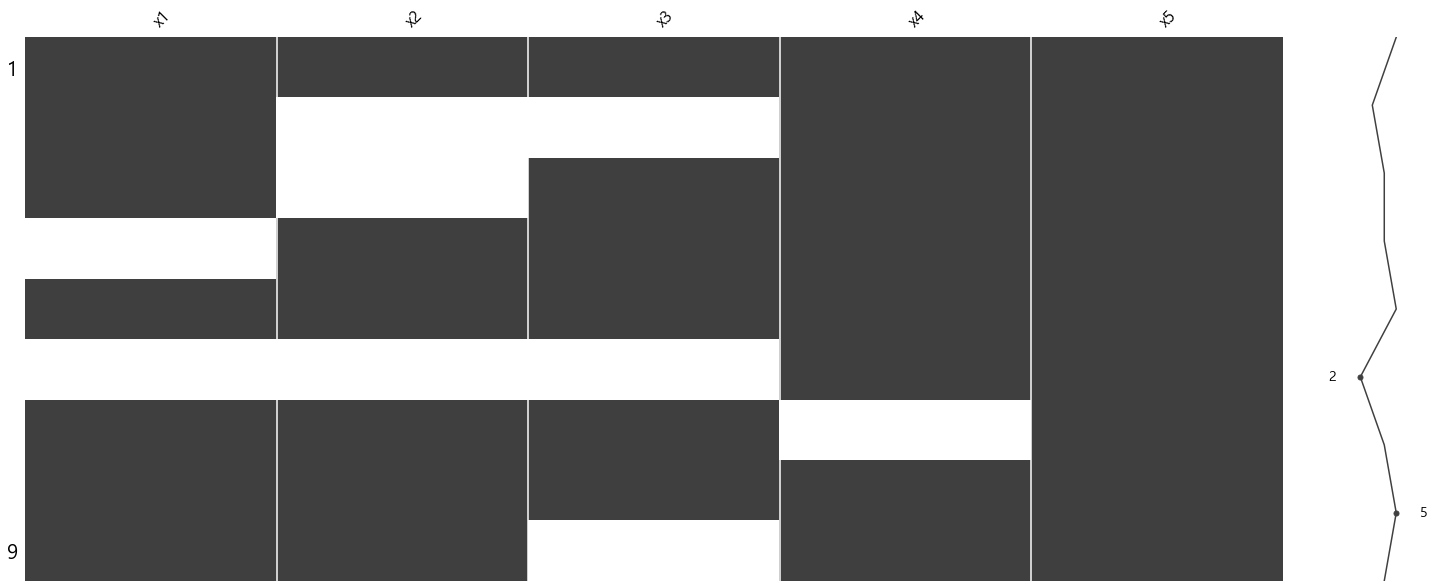

In [94]:
#df.isnull().sum()
msno.matrix(df) # 흰색이 결측값 들어있는 부분

<AxesSubplot:>

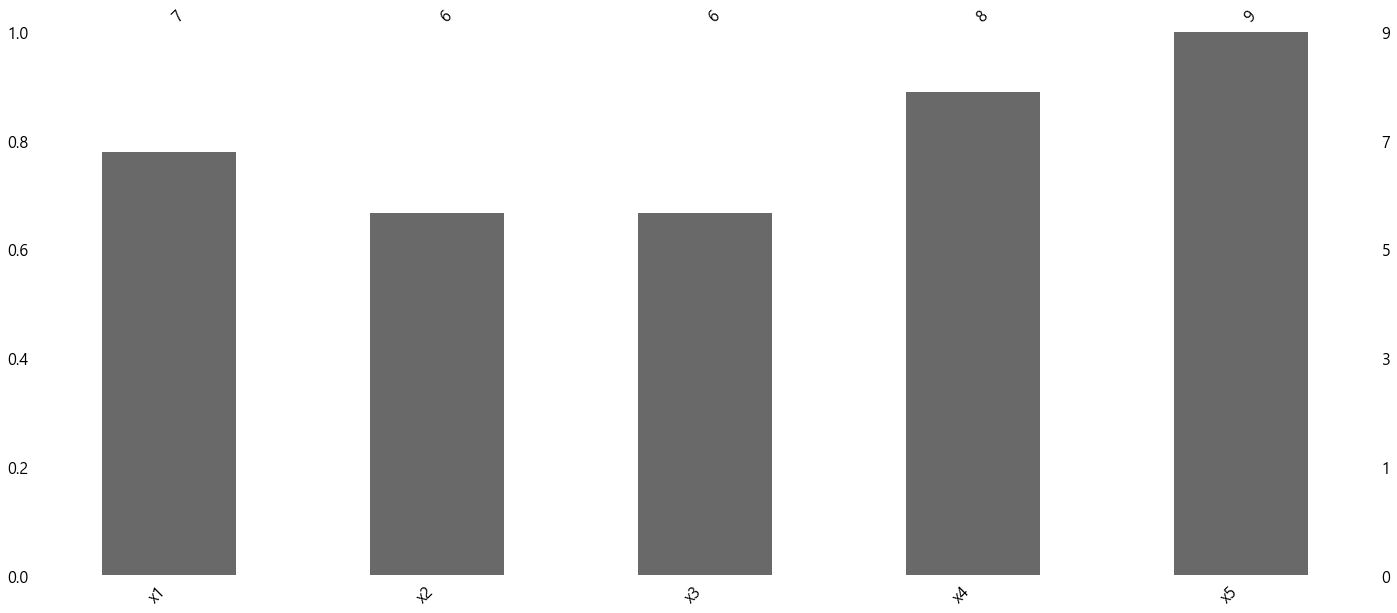

In [95]:
msno.bar(df)

In [97]:
titanic = sns.load_dataset('titanic')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


<AxesSubplot:>

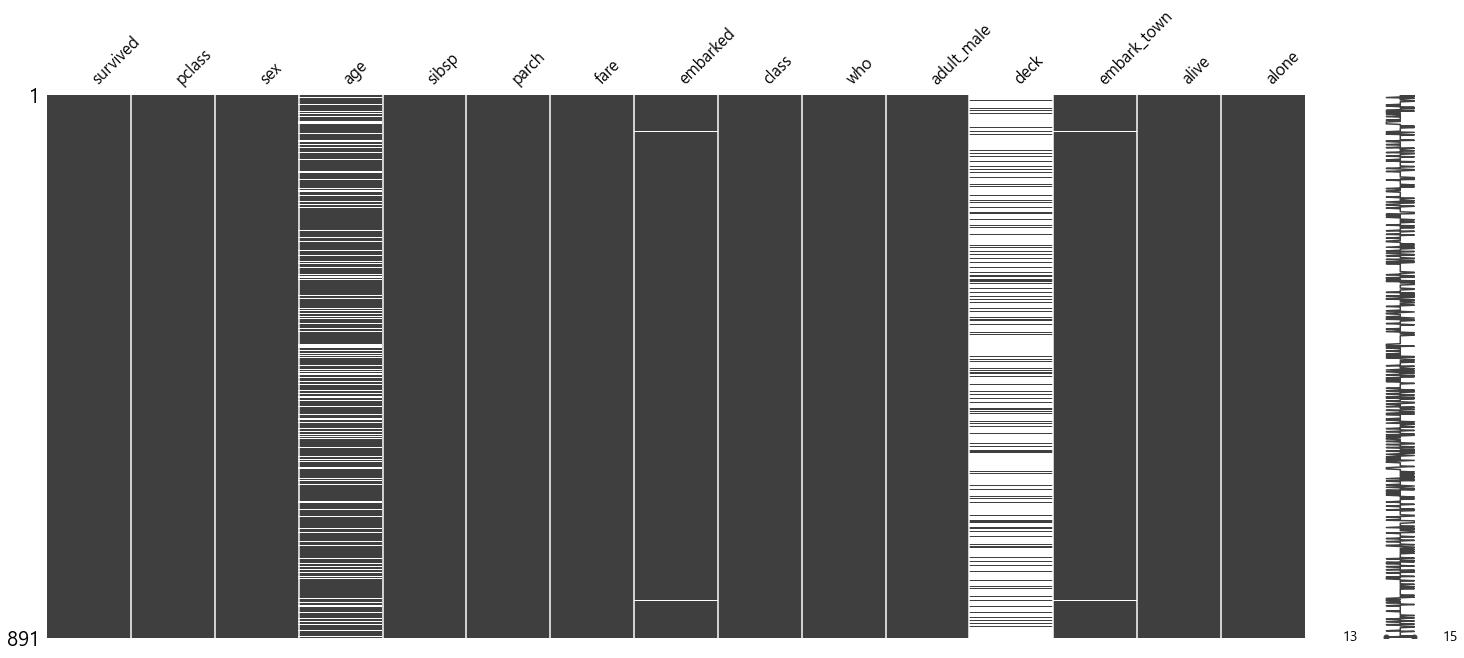

In [98]:
msno.matrix(titanic)

<AxesSubplot:>

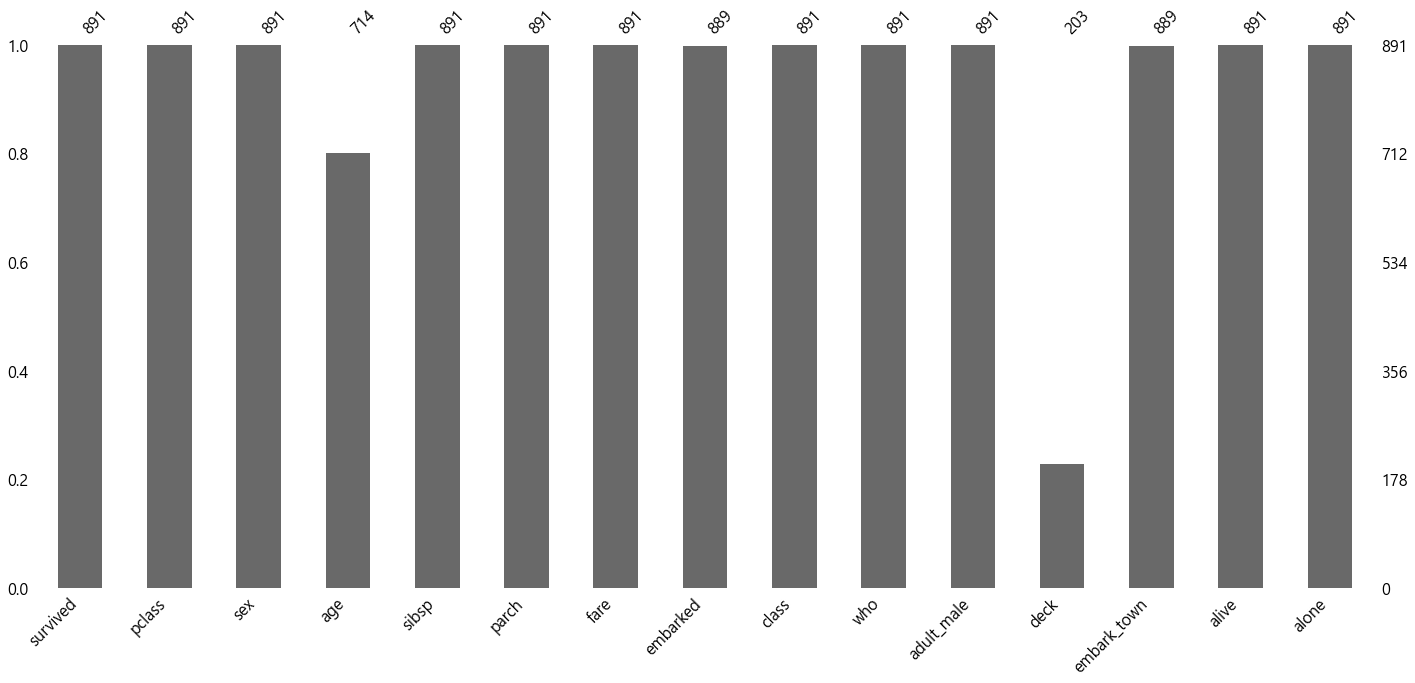

In [99]:
msno.bar(titanic)

In [104]:
df

,x1,x2,x3,x4,x5
0,1.0,0.1,1.0,2019-01-01,A
1,2.0,NaN,NaN,2019-01-02,B
2,3.0,NaN,3.0,2019-01-03,C
3,NaN,0.4,4.0,2019-01-04,A
4,5.0,0.5,5.0,2019-01-05,B
5,NaN,NaN,NaN,2019-01-06,C
6,7.0,0.7,7.0,NaN,A
7,8.0,0.8,8.0,2019-01-08,B
8,9.0,0.9,NaN,2019-01-09,C


In [105]:
# 결측값 삭제하지 않고 특정값(평균값, 중앙값, 최빈값)으로 대체한다면?
imputer = SimpleImputer(strategy= 'most_frequent')
df = pd.DataFrame(imputer.fit_transform(df),
                 columns = df.columns)
df

,x1,x2,x3,x4,x5
0,1.0,0.1,1.0,2019-01-01,A
1,2.0,0.1,1.0,2019-01-02,B
2,3.0,0.1,3.0,2019-01-03,C
3,1.0,0.4,4.0,2019-01-04,A
4,5.0,0.5,5.0,2019-01-05,B
5,1.0,0.1,1.0,2019-01-06,C
6,7.0,0.7,7.0,2019-01-01,A
7,8.0,0.8,8.0,2019-01-08,B
8,9.0,0.9,1.0,2019-01-09,C


In [102]:
if titanic['age'].isna()==True:

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: age, Length: 891, dtype: bool

In [114]:
titanic_df['deck'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: deck, dtype: int64

In [120]:
# age는 평균값으로 대체, deck는 가장 적은 'G'로
titanic_df = sns.load_dataset('titanic')
titanic_df

titanic_age_imputer = SimpleImputer(strategy= 'mean')
titanic_df['age'] = titanic_age_imputer.fit_transform(titanic_df[['age']])
            
titanic_df['deck'] = titanic_df['deck'].fillna('G')
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000000,1,0,7.2500,S,Third,man,True,G,Southampton,no,False
1,1,1,female,38.000000,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000000,0,0,7.9250,S,Third,woman,False,G,Southampton,yes,True
3,1,1,female,35.000000,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000000,0,0,8.0500,S,Third,man,True,G,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,Second,man,True,G,Southampton,no,True
887,1,1,female,19.000000,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,29.699118,1,2,23.4500,S,Third,woman,False,G,Southampton,no,False
889,1,1,male,26.000000,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


<AxesSubplot:>

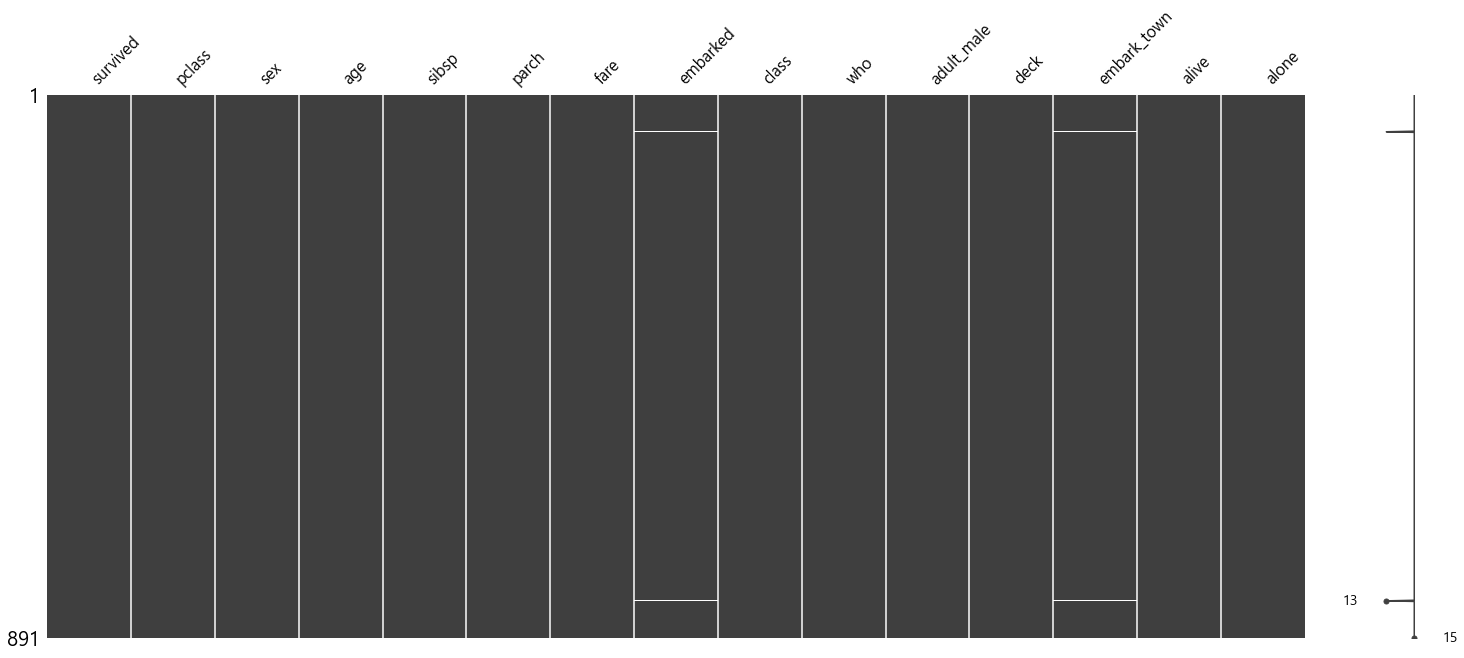

In [119]:
msno.matrix(titanic_df)

### Feature Scaling  
- 정규화(0과 1사이의 값으로 변환 - MinMaxScalar) 
- 정규화 공식 : (x-x최소값)/(x최대값 - x최소값)
    - 만약 음수일 경우 1로 대체됨.
- 표준화(정규분포를 따르는 형식으로 평균이 0 분산 1 가우시안 분포 변환 - StandardScalar)
- 표준화 공식 : (x-x평균값)/(x표준편차)
- Feature Scaling이 필요한 이유?
    - 서로 다른 피처의 유닛을 맞춰주기 위해서. 
    - 1.변수 값의 범위 또는 단위가 달라서 발생 가능한 문제를 예방할 수 있다.
    - 2.머신러닝 모델이 특정 데이터의 편향성을 갖는 걸 방지할 수 있다.
    - 3.데이터 범위 크기에 따라 모델이 학습하는 데 있어서 bias가 달라질 수 있으므로 하나의 범위 크기로 통일해주는 작업이 필요할 수 있다.


In [124]:
iris_frm = pd.DataFrame(data = iris.data,
                       columns = iris.feature_names)
print('mean:\n',iris_frm.mean())
print('std:\n',iris_frm.std())
print('var:\n',iris_frm.var())


mean:
 sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64
std:
 sepal length (cm)    0.828066
sepal width (cm)     0.435866
petal length (cm)    1.765298
petal width (cm)     0.762238
dtype: float64
var:
 sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
dtype: float64


In [127]:
# 표준화
s_scaler = StandardScaler()
# s_scaler.fit(iris_frm)
# s_iris = s_scaler.transform(iris_frm)
s_iris = s_scaler.fit_transform(iris_frm) # 위의 주석처리된 2문장을 한번에 처리하는 문장.
s_iris_frm = pd.DataFrame(data=s_iris,
                         columns = iris.feature_names)
s_iris_frm

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [128]:
# 정규화
m_scaler = MinMaxScaler()
m_scaler.fit(iris_frm)
m_iris = m_scaler.transform(iris_frm)
#m_iris = m_scaler.fit_transform(iris_frm) # 위의 2문장을 한번에 처리하는 문장.
m_iris_frm = pd.DataFrame(data=m_iris,
                         columns = iris.feature_names)
m_iris_frm

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


### ☆중요☆ 스케일링 변환시 주의점!! 

In [130]:
# 예제를 통해서 문제점을 파악해보자

train_data = np.arange(0,11).reshape(-1,1)
print('train_data :')
print(train_data)

test_data = np.arange(0,6).reshape(-1,1)
print('test_data : ')
print(test_data)

train_data :
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
test_data : 
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [132]:
# 학습데이터의 정규화
scaler = MinMaxScaler()
scaler.fit(train_data)
m_train_data = scaler.transform(train_data)
print('원본데이터 : ', train_data.reshape(-1))
print('정규화 데이터 : ', m_train_data.reshape(-1))

원본데이터 :  [ 0  1  2  3  4  5  6  7  8  9 10]
정규화 데이터 :  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [133]:
# 테스트데이터의 정규화

scaler.fit(test_data)
m_test_data = scaler.transform(test_data)
print('원본데이터 : ', test_data.reshape(-1))
print('정규화 데이터 : ', m_test_data.reshape(-1))

print()
print('위 코드의 문제점은 테스트데이터의 스케일링 기준을 잡아야 한다.')
print('왜냐하면? 학습기는 학습데이터를 기준으로 학습을 진행하기 때문에')

원본데이터 :  [0 1 2 3 4 5]
정규화 데이터 :  [0.  0.2 0.4 0.6 0.8 1. ]


In [134]:
# 학습데이터 기준의 테스트데이터 스케일링을 통한 문제점 해결!
scaler = MinMaxScaler()
scaler.fit(train_data)
m_train_data = scaler.transform(train_data)
print('원본데이터 : ', train_data.reshape(-1))
print('정규화 데이터 : ', m_train_data.reshape(-1))

m_test_data = scaler.transform(test_data)
print('원본데이터 : ', test_data.reshape(-1))
print('정규화 데이터 : ', m_test_data.reshape(-1))


원본데이터 :  [ 0  1  2  3  4  5  6  7  8  9 10]
정규화 데이터 :  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
원본데이터 :  [0 1 2 3 4 5]
정규화 데이터 :  [0.  0.1 0.2 0.3 0.4 0.5]


### 스케일링 전, 후의 정확도 비교[실습]
https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv


In [138]:
sample_frm = pd.io.parsers.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv',
                                  header = None,
                                   usecols=[0,2,13])
sample_frm.columns = ['target','x','y']
sample_frm

,target,x,y
0,1,1.71,1065
1,1,1.78,1050
2,1,2.36,1185
3,1,1.95,1480
4,1,2.59,735
...,...,...,...
173,3,5.65,740
174,3,3.91,750
175,3,4.28,835
176,3,2.59,840


In [157]:
train_data_x = sample_frm['x'].values.reshape(-1, 1)
test_data =sample_frm['y'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(train_data_x)
print('-----train_data-----')
m_train_data_x = scaler.transform(train_data_x)
print('원본데이터 : ', train_data_x.reshape(-1))
print('정규화 데이터 : ', m_train_data_x.reshape(-1))

print('-----test_data-----')
m_test_data = scaler.transform(test_data)
print('원본데이터 : ', test_data.reshape(-1))
print('정규화 데이터 : ', m_test_data.reshape(-1))

-----train_data-----
원본데이터 :  [1.71 1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 1.48 1.73 1.73
 1.87 1.81 1.92 1.57 1.59 3.1  1.63 3.8  1.86 1.6  1.81 2.05 1.77 1.72
 1.9  1.68 1.5  1.66 1.83 1.53 1.8  1.81 1.64 1.65 1.5  3.99 1.71 3.84
 1.89 3.98 1.77 4.04 3.59 1.68 2.02 1.73 1.73 1.65 1.75 1.9  1.67 1.73
 1.7  1.97 1.43 0.94 1.1  1.36 1.25 1.13 1.45 1.21 1.01 1.17 0.94 1.19
 1.61 1.51 1.66 1.67 1.09 1.88 0.9  2.89 0.99 3.87 0.92 1.81 1.13 3.86
 0.89 0.98 1.61 1.67 2.06 1.33 1.83 1.51 1.53 2.83 1.99 1.52 2.12 1.41
 1.07 3.17 2.08 1.34 2.45 1.72 1.73 2.55 1.73 1.75 1.29 1.35 3.74 2.43
 2.68 0.74 1.39 1.51 1.47 1.61 3.43 3.43 2.4  2.05 4.43 5.8  4.31 2.16
 1.53 2.13 1.63 4.3  1.35 2.99 2.31 3.55 1.24 2.46 4.72 5.51 3.59 2.96
 2.81 2.56 3.17 4.95 3.88 3.57 5.04 4.61 3.24 3.9  3.12 2.67 1.9  3.3
 1.29 5.19 4.12 3.03 1.68 1.67 3.83 3.26 3.27 3.45 2.76 4.36 3.7  3.37
 2.58 4.6  3.03 2.39 2.51 5.65 3.91 4.28 2.59 4.1 ]
정규화 데이터 :  [0.1916996  0.2055336  0.3201581  0.23913043 0.36561265 

In [173]:
# 스케일링 전 학습시켜보자 model 01

# 피처만 추출한다면?
sample_feature_frm = sample_frm.iloc[:,1:3]
# 레이블만 추출한다면?
sample_label_frm = sample_frm.iloc[:,0]
# 학습데이터와 테스트데이터로 분리
X_train,X_test,y_train,y_test=train_test_split(sample_feature_frm,
                                              sample_label_frm,
                                              test_size=0.2,
                                              random_state=100)
dtc01 = DecisionTreeClassifier(random_state = 100)
dtc01.fit(X_train,y_train)

y_predict = dtc01.predict(X_test)
print('y_test : ',y_test.values)
print('y_predict : ',y_predict)
print('예측정확도 : {0:.2f}'.format(accuracy_score(y_test, y_predict)))

y_test :  [2 3 1 2 3 3 2 2 2 2 3 2 3 3 3 1 3 1 2 1 3 1 2 2 1 1 2 2 2 3 3 2 1 2 3 3]
y_predict :  [2 2 1 2 2 3 2 2 3 2 3 2 2 3 3 1 1 1 3 1 3 1 2 2 1 1 3 2 2 3 3 2 1 2 2 2]
예측정확도 : 0.75


In [174]:
def feature_scaling(df, scaling_strategy="min-max", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df


In [176]:
# 스케일링 후 학습시켜보자 - model02
scaler_frm = feature_scaling(sample_frm,scaling_strategy = "min-max",
                            column=['x','y'])
scaler_frm

# 피처만 추출한다면?
s_feature_frm=scaler_frm.iloc[:,1:3]
# 레이블만 추출한다면?
s_label_frm = scaler_frm.iloc[:,0]

# 학습데이터와 테스트데이터로 분리
X_train1,X_test1,y_train1,y_test1=train_test_split(s_feature_frm,
                                              s_label_frm,
                                              test_size=0.2,
                                              random_state=100)

scaler = MinMaxScaler()
scaler.fit(X_train1)

m_train_data1= scaler.transform(X_train1)
m_test_data1 = scaler.transform(X_test1)

dtc02 = DecisionTreeClassifier(random_state = 100)
dtc02.fit(m_train_data1, y_train1)

# 새로운 데이터를(test) 이용해서 예측을 해보자
y_predict1 = dtc02.predict(m_test_data1)
print('y_test : ',y_test1.values)
print('y_predict : ',y_predict1)
print('예측정확도 : {0:.2f}'.format(accuracy_score(y_test1, y_predict1)))

# 결론 : 스케일링 전후 차이가 없음

y_test :  [2 3 1 2 3 3 2 2 2 2 3 2 3 3 3 1 3 1 2 1 3 1 2 2 1 1 2 2 2 3 3 2 1 2 3 3]
y_predict :  [2 2 1 2 2 3 2 2 3 2 3 2 2 3 3 1 1 1 3 1 3 1 2 2 1 1 3 2 2 3 3 2 1 2 2 2]
예측정확도 : 0.75
